In [1]:
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
import tweepy
import json
import os
from collections import Counter
import numpy as np
from collections import defaultdict
from matplotlib import pyplot as plt
import time
from datetime import datetime
from dateutil.parser import parse

In [2]:
#df for cornona cases

df_corona=pd.read_csv("corona_data.csv")

df_corona
#rename unnamed columns to Date

df_corona.rename( columns={'Unnamed: 0':'Date'}, inplace=True )
#same dates format to Climate change 
Date_list= df_corona["Date"].values
dates = []
for date in Date_list:
    dates.append(parse(date).date())
df_corona["Date"]=dates
print(df_corona)




          Date  total_cases  total_deaths  log_total_cases  log_total_deaths
0   2020-01-22          555            17         2.744293          1.230449
1   2020-01-23          654            18         2.815578          1.255273
2   2020-01-24          941            26         2.973590          1.414973
3   2020-01-25         1434            42         3.156549          1.623249
4   2020-01-26         2118            56         3.325926          1.748188
..         ...          ...           ...              ...               ...
83  2020-04-14      1976191        125983         6.295829          5.100312
84  2020-04-15      2056054        134176         6.313035          5.127675
85  2020-04-16      2152437        143800         6.332930          5.157759
86  2020-04-17      2240190        153821         6.350285          5.187016
87  2020-04-18      2317758        159509         6.365068          5.202785

[88 rows x 5 columns]


In [3]:
#df for climate change
df_c_Change=pd.read_csv("climate_data.csv")
df_c_Change
df2=df_c_Change.drop([0, 1])
df2
df2.rename( columns={'Unnamed: 0':'Date'}, inplace=True )
df2

,Date,id,favorite_count,retweet_count
2,2020-04-14,261,302,78392
3,2020-04-15,7717,11854,1078744
4,2020-04-16,8173,12127,781434
5,2020-04-17,8652,13027,753467
6,2020-04-18,6719,17419,432779
7,2020-04-19,6771,10418,697365
8,2020-04-20,9687,15123,1150229
9,2020-04-21,9856,15031,788037
10,2020-04-22,21936,34818,2586017


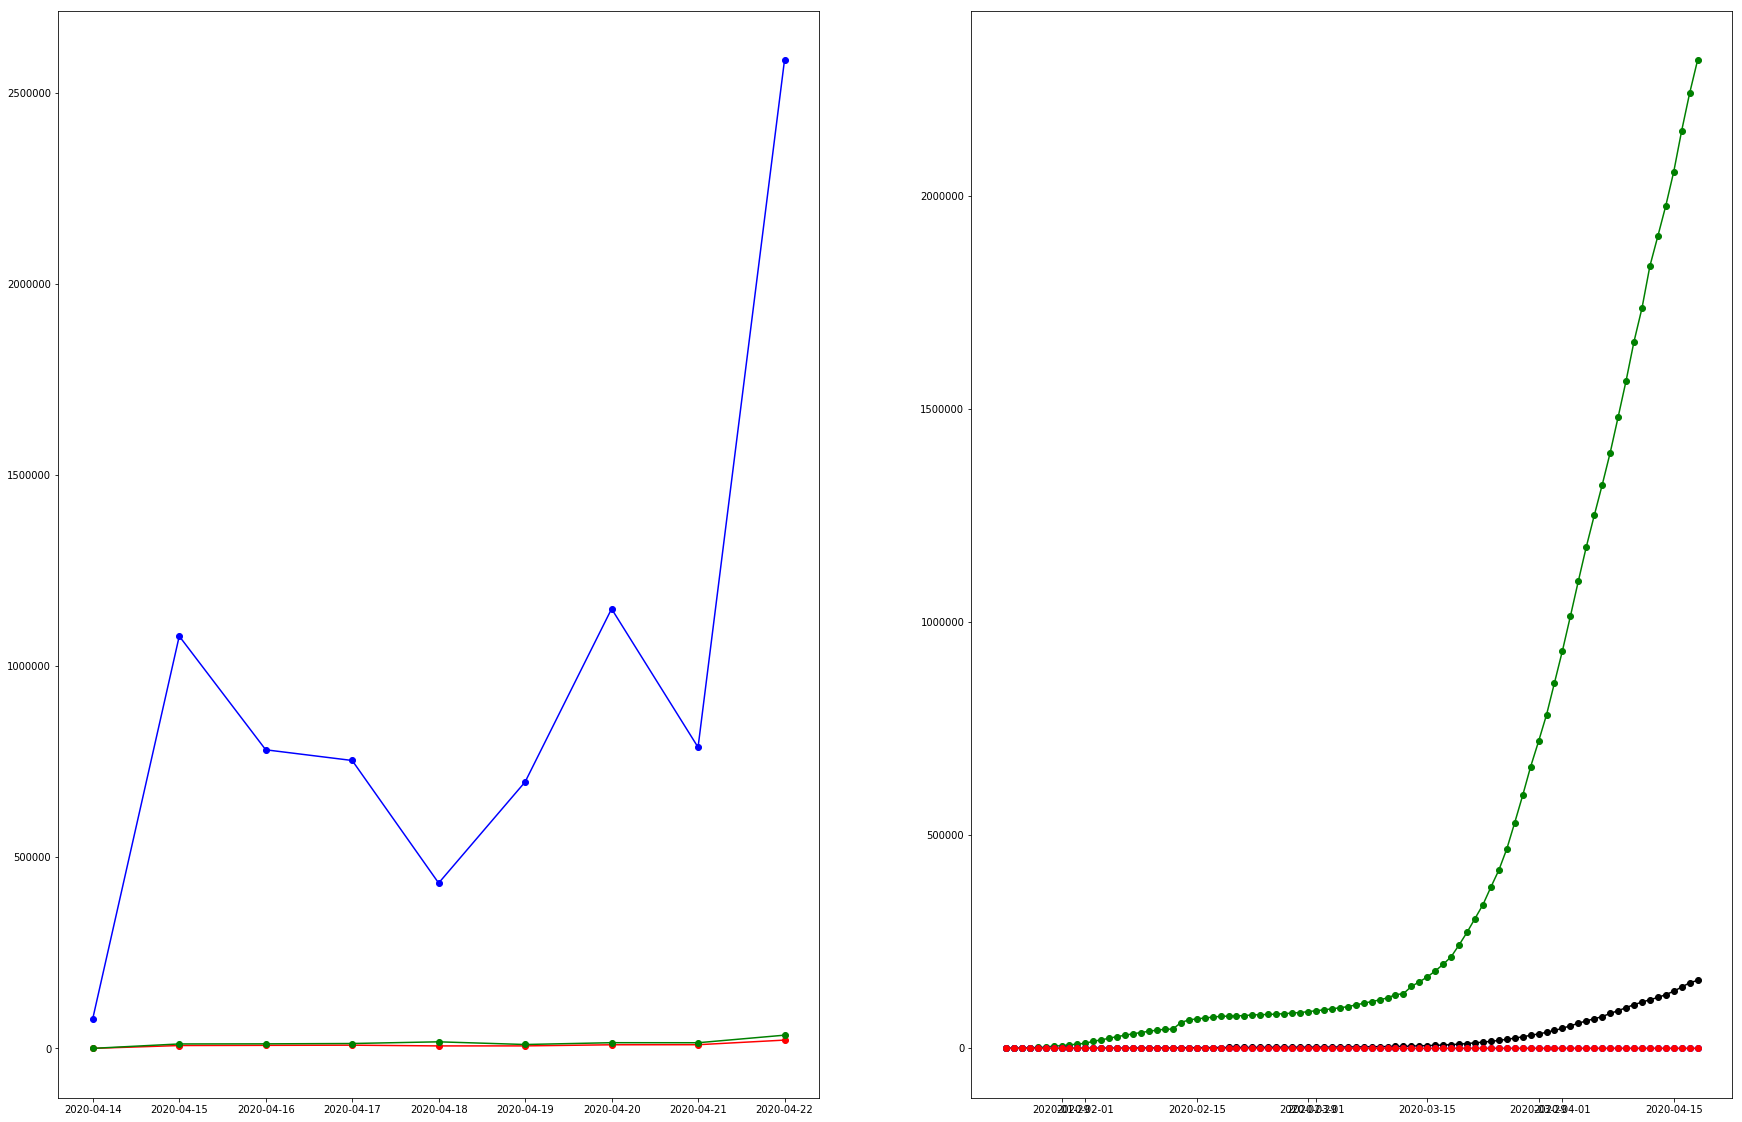

In [14]:
plt.figure(figsize=(30,20))
plt.subplot(1,2,1)
tweetid=[]
retweet_count=[]
fav_count=[]

y_colors=["red", "green", "blue"]
y_keyword=["id", "favorite_count","retweet_count"]

x_values = df2.Date

for y,c in zip(y_keyword, y_colors):
    #tweets grouped by id's
    y_values1 = list(df2[y])
    y_values1=[int(x)for x in y_values1]
    plt.plot(x_values, y_values1, color=c, marker="o", linestyle="-") 

y_colors=["green", "black","blue", "red"]
y_keyword1=["total_cases", "total_deaths","log_total_cases", "log_total_deaths"]

plt.subplot(1, 2,2)

x_values2=df_corona.Date
for y,c in zip(y_keyword1, y_colors):
    #tweets grouped by id's
    y_values1 = list(df_corona[y])
    y_values1=[int(x)for x in y_values1]    
    
    plt.plot(x_values2, y_values1, color=c, marker="o", linestyle="-")   
    